In [41]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from random import sample, choices

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, recall_score

from indicators import get_indicators, get_data

In [2]:
vix = get_indicators('^VIX', sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                     
                        missing_day = None)[['Price', 'macd']]
vix.rename(columns={'Price':'VIX', 'macd':'vix_macd'}, inplace=True)
vix_change = vix.pct_change(periods=1)
vix_change

,VIX,vix_macd
Date,,
2010-01-04,NaN,NaN
2010-01-05,-0.034431,-inf
2010-01-06,-0.009819,0.810913
2010-01-07,-0.005219,0.383586
2010-01-08,-0.048793,0.719165
...,...,...
2022-03-16,-0.105934,-0.083161
2022-03-17,-0.037495,-0.123848
2022-03-18,-0.070121,-0.178026


In [3]:
df = get_indicators('JPM', sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                        missing_day = None)

In [4]:
df.merge(vix, left_index=True, right_index=True)

,Price,Volume,sma,bb_pct,momentum,cci,so,macd,VIX,vix_macd
Date,,,,,,,,,,
2010-01-04,31.524035,35460500,NaN,NaN,NaN,NaN,NaN,0.000000,20.040001,0.000000
2010-01-05,32.134659,41208300,NaN,NaN,NaN,NaN,NaN,0.007611,19.350000,-0.008600
2010-01-06,32.311222,27729000,NaN,NaN,NaN,NaN,NaN,0.013890,19.160000,-0.015575
2010-01-07,32.951275,44864700,NaN,NaN,NaN,NaN,NaN,0.026013,19.059999,-0.021549
2010-01-08,32.870335,33110100,NaN,NaN,NaN,NaN,NaN,0.036107,18.129999,-0.037046
...,...,...,...,...,...,...,...,...,...,...
2022-03-16,138.399994,20354900,139.730999,0.537517,89.451908,-23.141670,37.827685,-5.219832,26.670000,1.811662
2022-03-17,140.149994,17050500,138.988499,0.464210,90.419351,-2.340548,49.706345,-5.049926,25.670000,1.587291
2022-03-18,140.100006,23605900,138.421999,0.444631,92.518004,15.158240,49.496665,-4.783904,23.870001,1.304712


In [5]:
def calc_class_prob(symbol, n_days, percent_change, 
                    indicators= ['sma', 'bb_pct', 'momentum', 'cci', 'so', 'macd'], 
                    verbose=True):
    rolling=False
    roll_window = 5    
    
    df = get_indicators(symbol, sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                        missing_day = None)
    vix = get_indicators('^VIX', sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                        missing_day = None)[['Price', 'macd']]
    vix.rename(columns={'Price':'VIX', 'macd':'vix_macd'}, inplace=True)
    df = df.merge(vix, left_index=True, right_index=True)
    
    #all - given = dropped
    drop_cols = set(df.columns) - set(indicators)
    
    if rolling:
        df_rolling = df[indicators].rolling(roll_window).mean()
        df_rolling.columns = [x + f'_rolling_{str(roll_window)}' for x in df_rolling.columns]
        df = pd.concat([df, df_rolling], axis=1)
            
    days_ahead = n_days * -1
    
    df.dropna(axis=0, inplace=True)
    
    predict_index = df.index[days_ahead:]

    df['window_change'] = df['Price'].pct_change(periods=days_ahead)
    day_change = df['Price'].copy().pct_change(periods=1)[days_ahead:]
    df['norm_returns'] = df['Price']/df['Price'][0] - 1 
    
    assert percent_change != 0, 'percentage change not be 0!'
    
    # positive class is a no change so that sklearn's recall metric can be used without me coding anything extra
    if percent_change > 0:
        y = np.where(df['window_change'] >= percent_change, 1, 0)
    else:
        y = np.where(df['window_change'] <= percent_change, 1, 0)
        
    #prep X
    split = int(len(df) * 0.8)
    ret_train_df = df[['window_change', 'norm_returns']].copy()[:split]
    ret_test_df = df[['window_change', 'norm_returns', 'Price']].copy()[split:  n_days*-1]
    ret_test_df['norm_returns'] = ret_test_df['Price']/ret_test_df['Price'][0] - 1
    ret_test_df.drop(columns=['Price'], inplace=True)
    #df.drop(columns = drop_cols, inplace=True)
    df.drop(columns = list(drop_cols) + ['window_change', 'norm_returns'], inplace=True)

       
    scale = StandardScaler().fit(df)
    X = scale.transform(df)
    
    X_train = X[:split]
    y_train = y[:split]
    X_test = X[split:  n_days*-1]
    y_test = y[split : n_days*-1]
    
    X_predict = X[n_days*-1:]
    
    # cross validate
    parameters = {'n_estimators':[10, 25, 50, 100], 
              'max_depth':[2, 3, 4],
              'max_features':['sqrt', 'log2']}
    
    #@todo:  Nick, confirm time series split not needed for RF--lagged indicators built into features, not the model.
    #tscv = TimeSeriesSplit(n_splits=3)
    
    #rf_class = RandomForestClassifier(random_state=123)
    rf_class = GradientBoostingClassifier(random_state=123)
    
    
    clf = GridSearchCV(rf_class,
                   param_grid=parameters,
                   scoring='recall', # make recall postive class 0 to calculate specificity
                   cv=5,  #tscv
                   n_jobs=-1,
                   verbose=False)
    
    
    clf.fit(X_train, y_train)
    
    if verbose:
        print(clf.best_params_)
        
    # predict y
    #ret_train_df['y_hat_train'] = clf.predict(X_train)
    ret_train_df['positive_class'] = np.round(clf.predict_proba(X_train), 3)[:,1]
    ret_test_df['y_hat_test'] = clf.predict(X_test)
    ret_test_df['positive_class'] = np.round(clf.predict_proba(X_test), 3)[:,1]
    
    # predict holdout prediction (days ahead)
    hold_out_probs = np.round(clf.predict_proba(X_predict), 3)

    
    if verbose:
        print(classification_report(y_test, ret_test_df['y_hat_test']))
        
        plot_roc_curve(clf, X_test, y_test)
        plt.plot([0, 1], [0, 1])

        importance = pd.DataFrame(zip(df.columns, clf.best_estimator_.feature_importances_))
        #importance.sort_values(by=1, ascending=False)
        print(importance)

    ret_preds_df = pd.DataFrame(np.append(hold_out_probs, np.array([day_change]).T, axis=1), 
                        index=predict_index,
                        columns=['negative_class', 'positive_class', 'change'])
    
    return ret_preds_df, ret_train_df, ret_test_df
    

{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       418
           1       0.41      0.47      0.44       157

    accuracy                           0.67       575
   macro avg       0.60      0.61      0.60       575
weighted avg       0.69      0.67      0.68       575

          0         1
0       sma  0.132636
1    bb_pct  0.166211
2  momentum  0.140528
3        so  0.114258
4      macd  0.154180
5       VIX  0.292187


/home/troysattgast/miniconda3/envs/finance/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


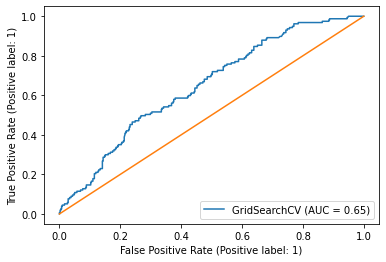

In [6]:
preds_df, train_df, test_df = calc_class_prob(symbol = 'voo',
                n_days = 2,
                percent_change = -0.01,
                indicators = ['sma', 'bb_pct', 'momentum', 'so', 'macd', 'VIX'],
                verbose = True)


In [7]:
train_df.loc[train_df['window_change'] > -0.01]

,window_change,norm_returns,positive_class
Date,,,
2010-10-07,-0.005822,0.000000,0.091
2010-10-08,-0.004108,0.007556,0.038
2010-10-12,-0.002235,0.011712,0.034
2010-10-13,0.001860,0.017756,0.023
2010-10-14,-0.009045,0.013978,0.062
...,...,...,...
2019-11-27,0.012085,2.267310,0.019
2019-11-29,0.015336,2.254794,0.044
2019-12-02,0.000664,2.228295,0.181


<AxesSubplot:xlabel='Date'>

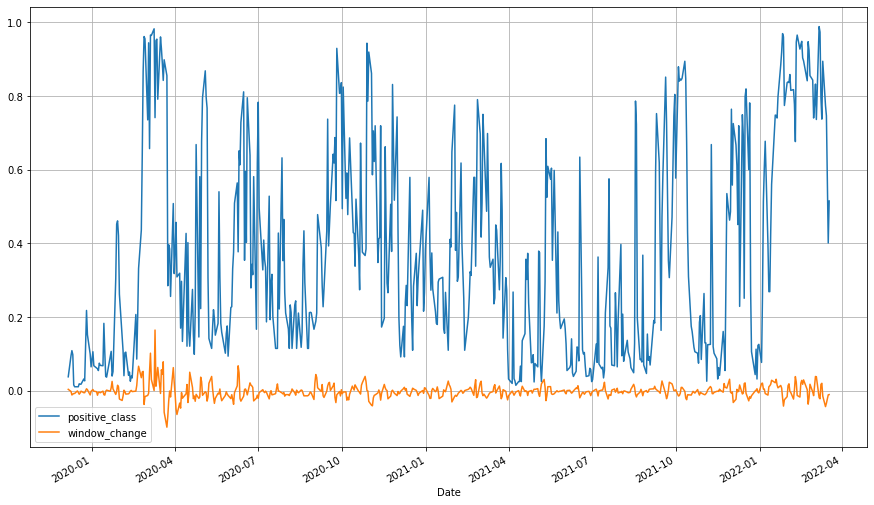

In [8]:
test_df[['positive_class', 'window_change']].plot(figsize=(15,9), grid=True)

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

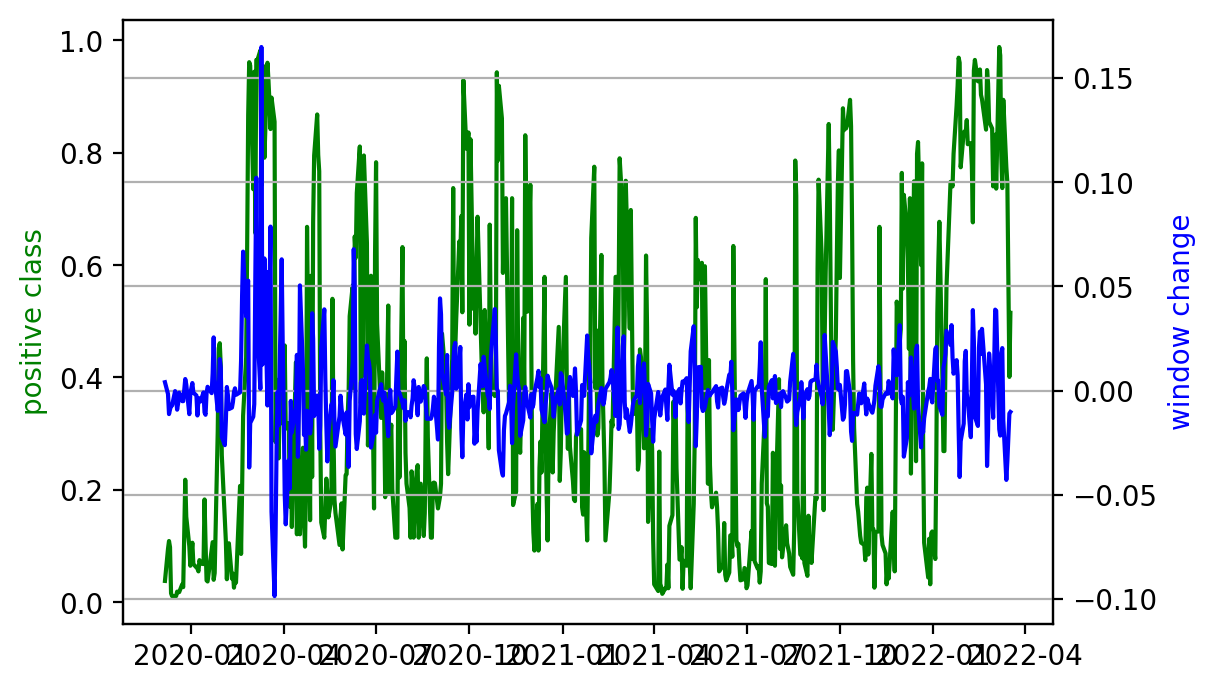

In [10]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(test_df['positive_class'], label='positive class', color = 'g')
ax2.plot(test_df['window_change'], label='window change', color='b')
ax1.set_ylabel('positive class', color='g')
ax2.set_ylabel('window change', color='b')
#plt.xticks(res.index, rotation=90)
fig.set_dpi(200)
plt.grid()
plt.show()

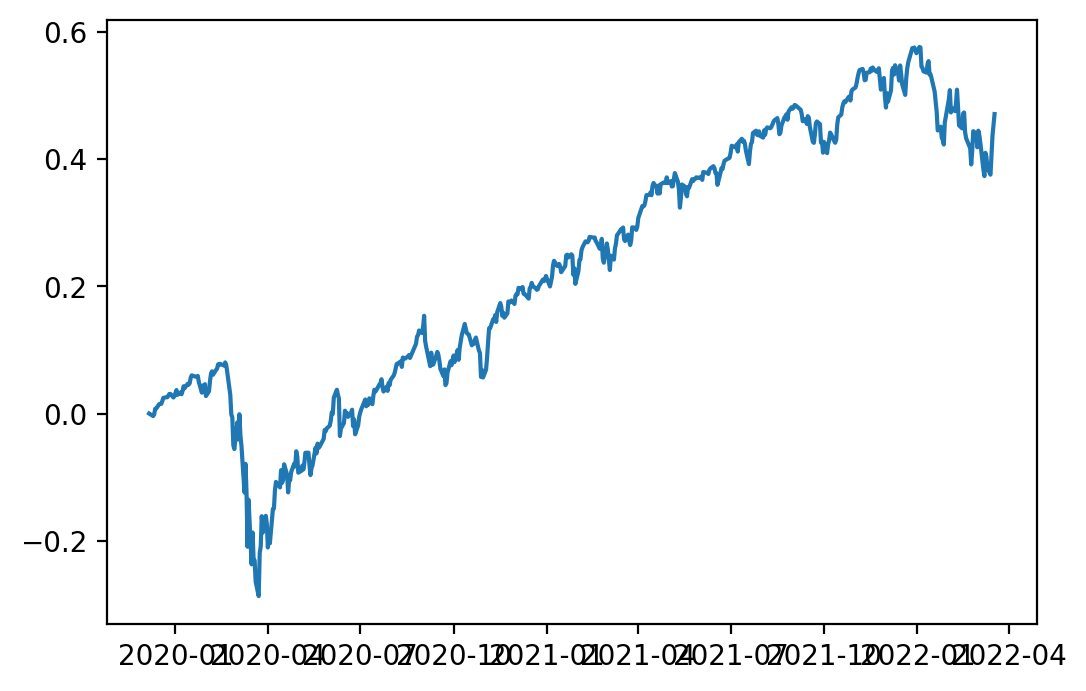

In [11]:
fig, ax = plt.subplots()
ax.plot(test_df['norm_returns'])
fig.set_dpi(200)


<AxesSubplot:xlabel='Date'>

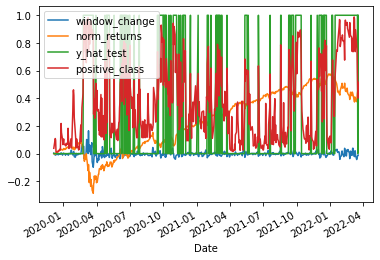

In [12]:
test_df.plot()

In [20]:
etfs = ['IWM', 'SNAP']
change = 0.01
days = 2


IWM


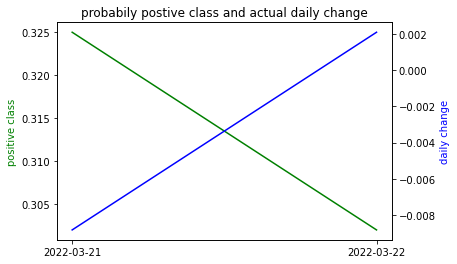


SNAP


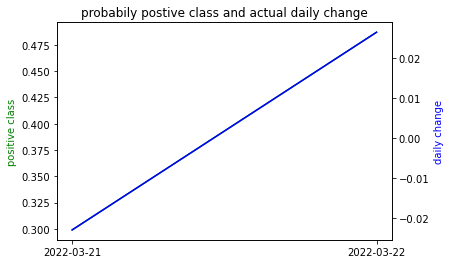

In [21]:
for fund in etfs:
    print('\n' + fund)
    res, train_df, test_df = calc_class_prob(symbol = fund, 
                n_days = days, 
                percent_change = change,
                indicators = ['sma', 'bb_pct', 'momentum', 'so', 'macd', 'VIX'],
                verbose = False)
    

    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(res['positive_class'], label='positive class', color='g')
    ax2.plot(res['change'], label='daily change', color='b')

    ax1.set_title('probabily postive class and actual daily change')
    ax1.set_ylabel('positive class', color='g')
    ax2.set_ylabel('daily change', color='b')
    plt.xticks(res.index, rotation=90)
    plt.show()

<AxesSubplot:xlabel='Date'>

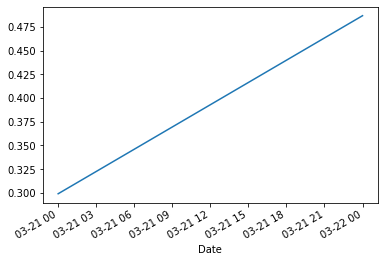

In [22]:
res['positive_class'].plot()

In [23]:
preds_df

,negative_class,positive_class,change
Date,,,
2022-03-21,0.489,0.511,0.000049
2022-03-22,0.664,0.336,0.010344


In [7]:
df.head()

,Price,Volume,sma,bb_pct,momentum,cci,so,macd
Date,,,,,,,,
2010-01-04,31.524035,35460500,NaN,NaN,NaN,NaN,NaN,0.000000
2010-01-05,32.134659,41208300,NaN,NaN,NaN,NaN,NaN,0.007611
2010-01-06,32.311222,27729000,NaN,NaN,NaN,NaN,NaN,0.013890
2010-01-07,32.951275,44864700,NaN,NaN,NaN,NaN,NaN,0.026013
2010-01-08,32.870335,33110100,NaN,NaN,NaN,NaN,NaN,0.036107


In [12]:
symbol = 'IWM'
rolling=False
roll_window = 5
n_days = 1
percent_change = 0.01
indicators= ['sma', 'bb_pct', 'momentum', 'cci', 'so', 'macd']

df = get_indicators(symbol, sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                    missing_day = None)
vix = get_indicators('^VIX', sd=dt.datetime(2010, 1, 1), ed=dt.date.today() + dt.timedelta(days=1),
                    missing_day = None)[['Price', 'macd']]
vix.rename(columns={'Price':'VIX', 'macd':'vix_macd'}, inplace=True)
df = df.merge(vix, left_index=True, right_index=True)

#all - given = dropped
drop_cols = set(df.columns) - set(indicators)

if rolling:
    df_rolling = df[indicators].rolling(roll_window).mean()
    df_rolling.columns = [x + f'_rolling_{str(roll_window)}' for x in df_rolling.columns]
    df = pd.concat([df, df_rolling], axis=1)

days_ahead = n_days * -1

df.dropna(axis=0, inplace=True)

predict_index = df.index[days_ahead:]

df['window_change'] = df['Price'].pct_change(periods=days_ahead)
day_change = df['Price'].copy().pct_change(periods=1)[days_ahead:]
df['norm_returns'] = df['Price']/df['Price'][0] - 1 

assert percent_change != 0, 'percentage change not be 0!'


In [46]:
datetime_idxs = df.loc[df['window_change'] >= percent_change].index.to_list()
maj_class_length = df.loc[df['window_change'] < percent_change].shape[0]
samps_up_num = maj_class_length - len(datetime_idxs)

samps = choices(datetime_idxs, k=samps_up_num)

df_up_sample = df.loc[samps]

In [49]:
df_even = pd.concat([df, df_up_sample])

5057

In [ ]:

# positive class is a no change so that sklearn's recall metric can be used without me coding anything extra
if percent_change > 0:
    y = np.where(df['window_change'] >= percent_change, 1, 0)
else:
    y = np.where(df['window_change'] <= percent_change, 1, 0)
